In [3]:
import csv

import numpy as np
import tensorflow as tf
import glob
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [31]:
# dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [32]:
data_list = glob.glob('model/keypoint_classifier/data/*.csv')


for i,dat in enumerate(data_list):
    if i == 0:
        data = np.genfromtxt(dat,delimiter=',')
    else:
        temp_data = np.genfromtxt(dat,delimiter=',')
        data = np.vstack((data,temp_data))
        
X_dataset = data[:,range(1,(21*2)+1)]
Y_dataset = data[:,0]

# Set number of classes

In [33]:
NUM_CLASSES = 5

# Dataset reading

In [21]:
# X_dataset = np.loadtxt('model/keypoint_classifier/keypoint_old.csv', delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
# X_dataset.shape

(4787, 42)

In [12]:
print(X_dataset)

NameError: name 'X_dataset' is not defined

In [34]:
# y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, Y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [36]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [37]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 42)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                860       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [39]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [45]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
32/32 [==============================] - 0s 5ms/step - loss: 0.5546 - accuracy: 0.7946 - val_loss: 0.2189 - val_accuracy: 0.9591

Epoch 00001: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 2/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5426 - accuracy: 0.8045 - val_loss: 0.2160 - val_accuracy: 0.9583

Epoch 00002: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 3/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5629 - accuracy: 0.7934 - val_loss: 0.2212 - val_accuracy: 0.9539

Epoch 00003: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 4/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5586 - accuracy: 0.7881 - val_loss: 0.2222 - val_accuracy: 0.9539

Epoch 00004: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
Epoch 5/1000
32/32 [==============================] - 0s 2ms/step - loss: 0.5702 - accuracy: 0.7790 - val_lo

In [42]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

11/11 [==============================] - 0s 939us/step - loss: 0.2328 - accuracy: 0.9501


In [46]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [47]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[6.5797329e-02 6.8716615e-02 8.6496985e-01 2.6929931e-05 4.8932375e-04]
2


# Confusion matrix

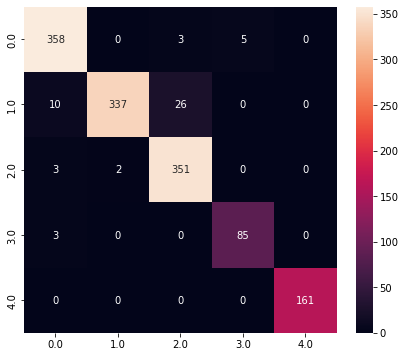

Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       366
         1.0       0.99      0.90      0.95       373
         2.0       0.92      0.99      0.95       356
         3.0       0.94      0.97      0.96        88
         4.0       1.00      1.00      1.00       161

    accuracy                           0.96      1344
   macro avg       0.96      0.97      0.96      1344
weighted avg       0.96      0.96      0.96      1344



In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [57]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [58]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

2021-09-18 15:14:47.322889: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/zn/_3stl7kj5xzdxw8p08_bvydc0000gn/T/tmpre1j7xks/assets


2021-09-18 15:14:47.741392: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-09-18 15:14:47.741481: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-09-18 15:14:47.742839: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2021-09-18 15:14:47.786761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2021-09-18 15:14:47.786777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.
2021-09-18 15:14:47.800264: I tensorflow/lite/tools/optimize/quantize_weights.cc:222] Skipping quantization of tensor sequential_1/dense_3/MatMul 

6448

# Inference test

In [59]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [60]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [65]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

ValueError: Cannot set tensor: Got value of type NOTYPE but expected type FLOAT32 for input 0, name: input_2 

In [64]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 41 µs, sys: 5 µs, total: 46 µs
Wall time: 49.8 µs


In [63]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.08546507 0.09256438 0.6720689  0.02732721 0.12257449]
2
